In [2]:
from IPython.display import display
import os

# 上傳檔案（會跳出檔案選擇器）
from ipywidgets import FileUpload

upload = FileUpload()
display(upload)


FileUpload(value={}, description='Upload')

In [3]:
import os
from pathlib import Path

# 假設你只上傳了一個檔案
# Check if any file is uploaded and get the filename
if upload.value:
    # Get the first (and likely only) filename from the dictionary keys
    filename = list(upload.value.keys())[0]
    fileinfo = upload.value[filename] # Access the file info dictionary using the filename as key
else:
    print("No file uploaded.")
    # Handle the case where no file is uploaded, perhaps by exiting or prompting the user.
    # For this example, we'll assume a file was uploaded as per the traceback context.
    raise FileNotFoundError("No file was uploaded.")


In [4]:
# 顯示內容結構（除錯用）
print(fileinfo)

# 儲存 kaggle.json
# filename is already obtained above
content = fileinfo['content']

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

kaggle_json_path = kaggle_dir / "kaggle.json"
with open(kaggle_json_path, "wb") as f:
    f.write(content)

{'metadata': {'name': 'kaggle.json', 'type': 'application/json', 'size': 64, 'lastModified': 1745215961986}, 'content': b'{"username":"suchiwen","key":"01a925cee9e9e9d232008524b0434fb9"}'}


In [5]:
# 設定權限（Linux/macOS 建議）
os.chmod(kaggle_json_path, 0o600)

print(f"{filename} 已成功儲存至 {kaggle_json_path}")

!kaggle datasets list -s cifar

!pip install -U kaggle
!pip install --upgrade pandas
import os
import zipfile

kaggle.json 已成功儲存至 /root/.kaggle/kaggle.json
ref                                                     title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
fedesoriano/cifar100                                    CIFAR-100 Python                                  168517809  2020-12-26 08:37:10.143000          12306        176  1.0              
pankrzysiu/cifar10-python                               CIFAR-10 Python                                   340613496  2018-01-27 13:42:40.967000          14834        253  0.75             
petitbonney/cifar10-image-recognition                   CIFAR-10                                         1007971063  2019-10-01 12:50:23.227000           2891         27  0.8235294        
valentynsi

In [6]:
# 建立 Kaggle 資料夾
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 下載 Dog Breed Identification 資料集
!kaggle competitions download -c dog-breed-identification --force
!unzip -oq dog-breed-identification.zip -d dog-breed-identification

cp: cannot stat 'kaggle.json': No such file or directory
 99% 681M/691M [00:02<00:00, 240MB/s]
100% 691M/691M [00:02<00:00, 283MB/s]


In [7]:
import glob
import random
import base64
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from IPython.display import HTML

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import numpy as np
import os,cv2,random,time,shutil,csv
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from tqdm import tqdm
import json,os,cv2 # Removed keras from this line as it will be imported explicitly from tensorflow.keras
# Corrected import path for ImageDataGenerator and other Keras components
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization,Dense,GlobalAveragePooling2D,Lambda,Dropout,InputLayer,Input, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import VGG16

# The rest of your code using these imported components should now work

In [8]:
# paths
path = r'../input/'
labels_csv_path = path + 'labels.csv'
# sample_submission_csv_path and submission_csv_path should point to the extracted directory
sample_submission_csv_path = 'dog-breed-identification/sample_submission.csv'
submission_csv_path =  'dog-breed-identification/sample_submission.csv' # Corrected path
train_path = 'dog-breed-identification/train' # Corrected path
test_path = 'dog-breed-identification/test' # Corrected path

number_of_epochs = 10

print(f'Constants are set. Fine tuning takes {number_of_epochs} epochs.')

Constants are set. Fine tuning takes 10 epochs.


In [9]:
import pandas as pd
import numpy as np
labels = pd.read_csv('dog-breed-identification/labels.csv')
samp_subm = pd.read_csv(submission_csv_path)
print(f'The shape of the labels: {labels.shape}')

The shape of the labels: (10222, 2)


In [10]:
labels = pd.read_csv('dog-breed-identification/labels.csv')

In [11]:
#資料夾中圖片檔案圖像的數量
print(len(os.listdir(train_path)))
print(len(os.listdir(test_path)))
#取得該欄位中所有唯一的品種名稱（去掉重複值）
unique_breeds = pd.unique(labels['breed'])
print(len(unique_breeds))

10222
10357
120


In [12]:
#計算每個狗品種（breed）對應的圖像數量，並依照數量從多到少排序
each_label = labels.groupby("breed").count()
each_label = each_label.rename(columns = {"id" : "count"})
each_label = each_label.sort_values("count", ascending=False)
each_label

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
brabancon_griffon,67
komondor,67


<ipython-input-13-59fa9a6cef98>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  ax = pd.value_counts(labels['breed'],ascending=True).plot(kind='barh',


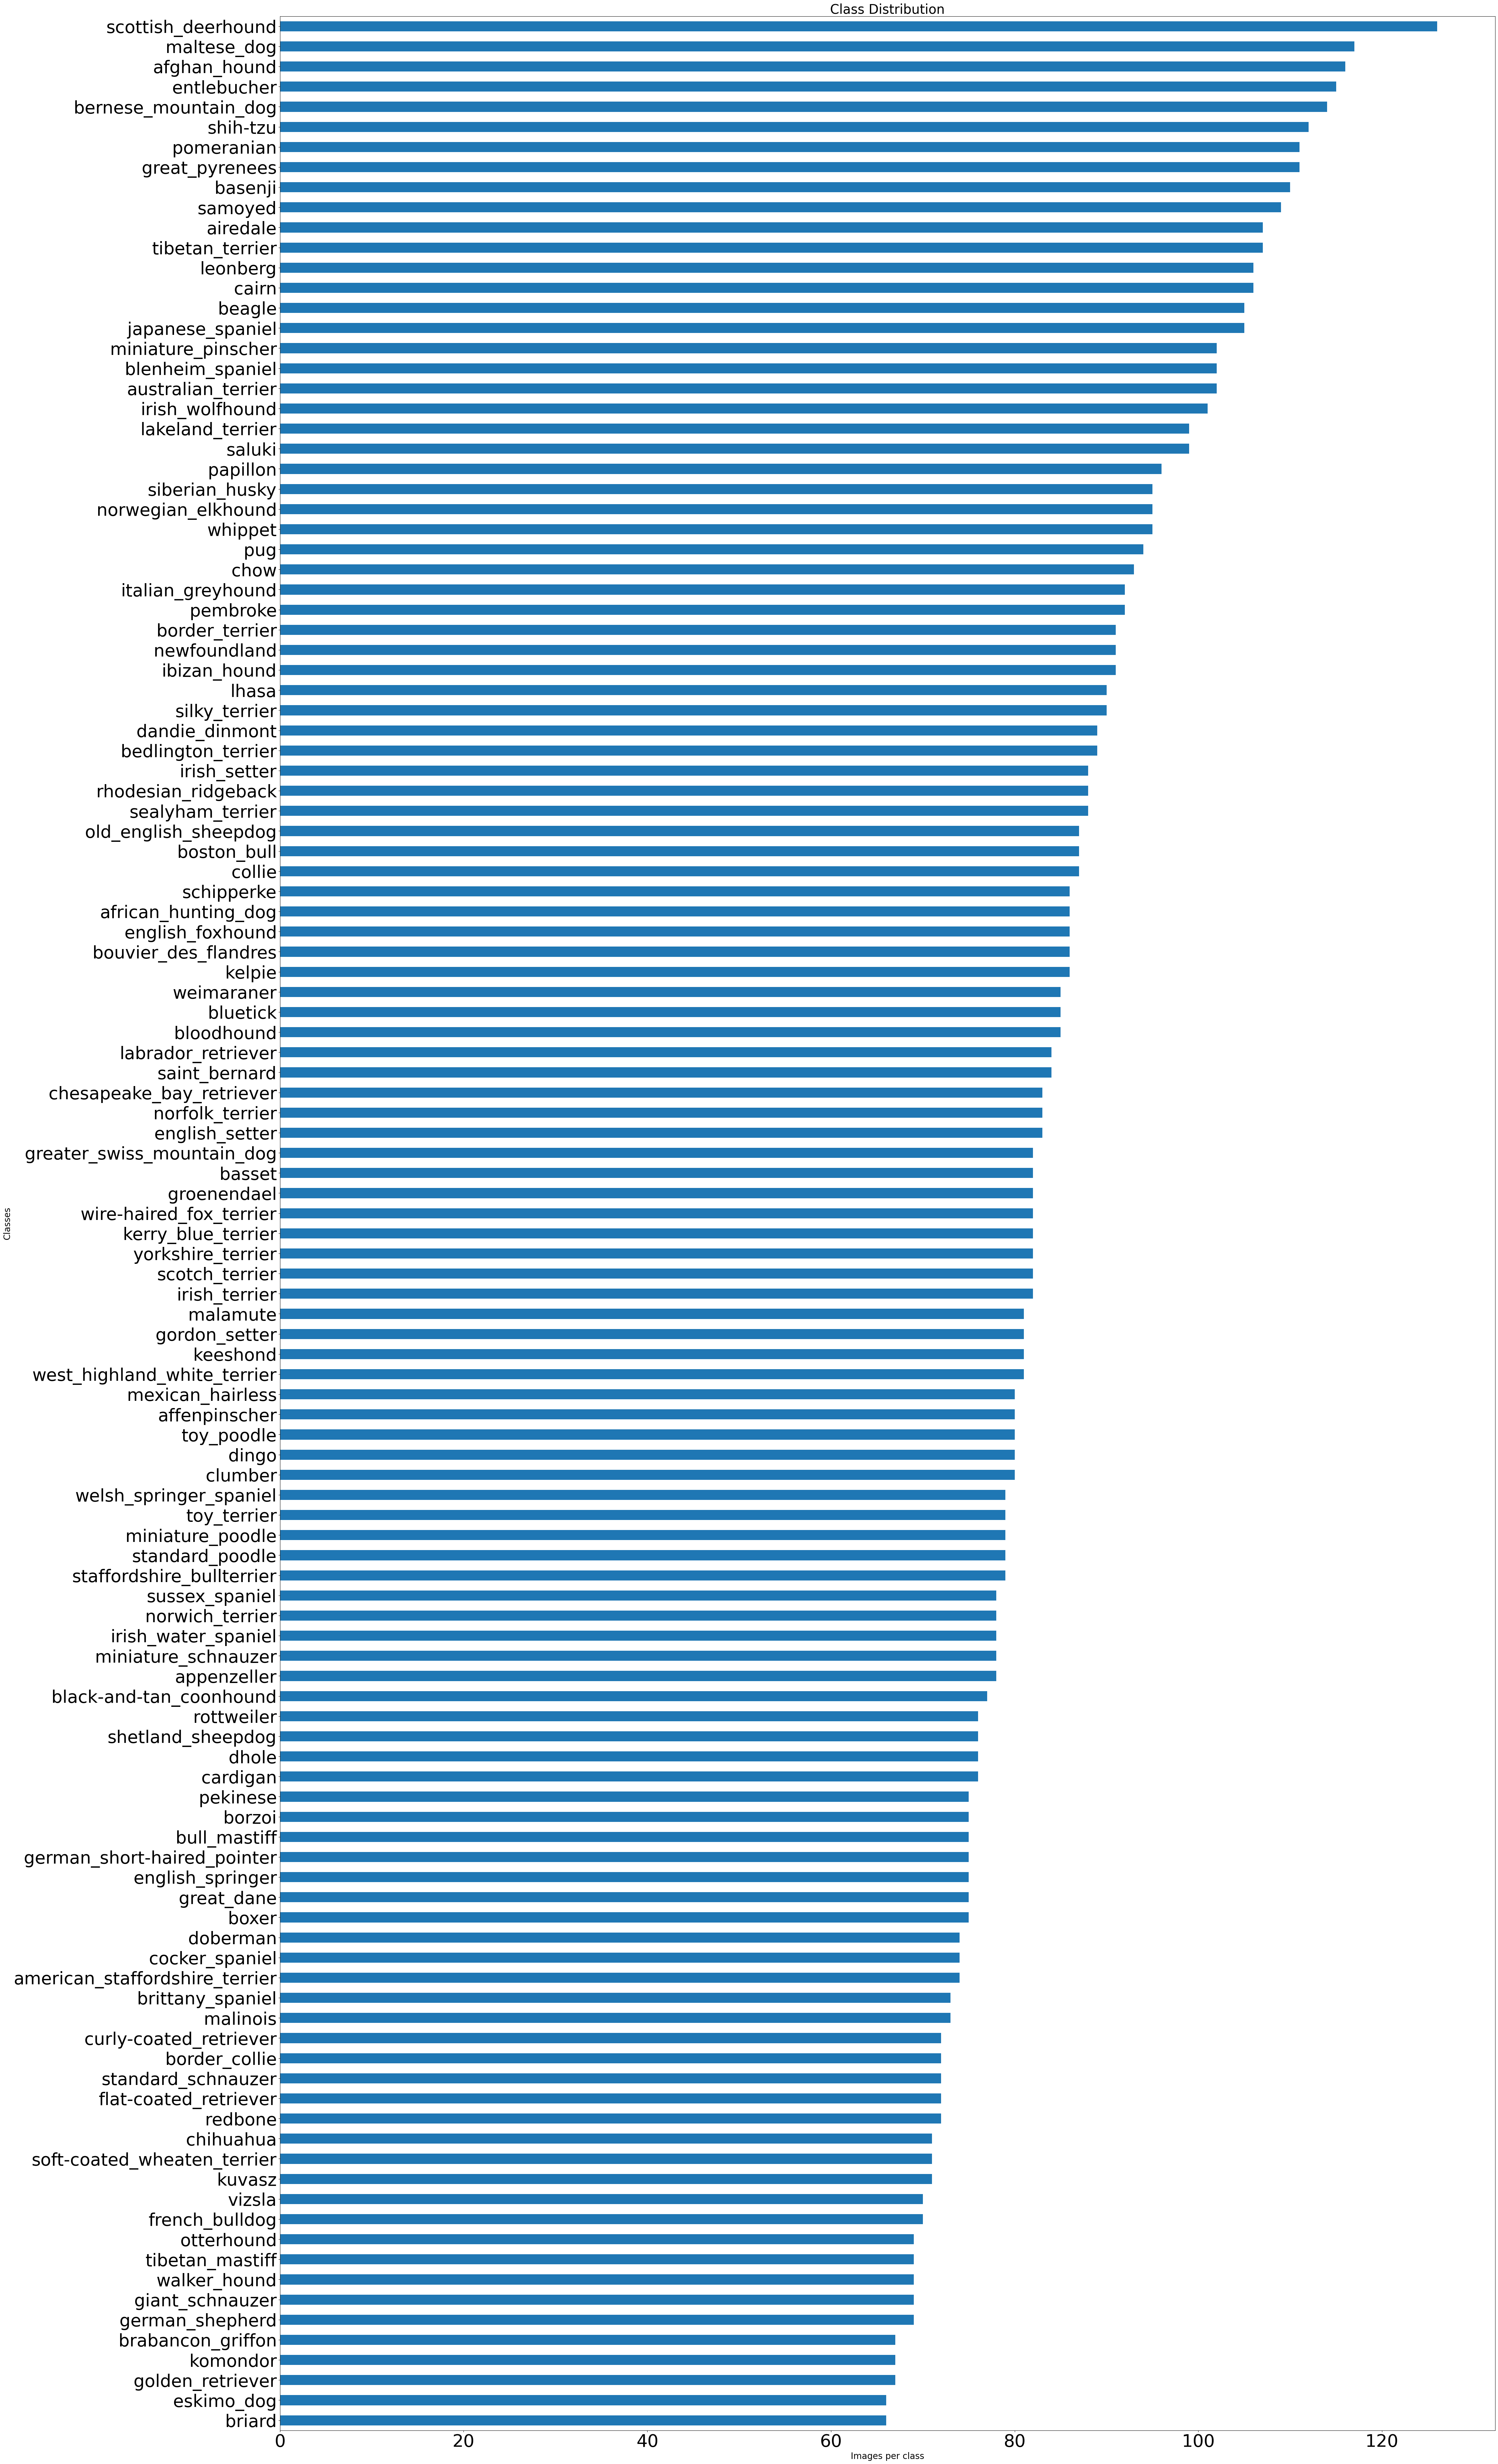

In [13]:
#可視化狗品種分類的類別分佈
ax = pd.value_counts(labels['breed'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Class Distribution",
                                                       figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(30)

In [14]:
# pd.set_option('display.max_colwidth', -1) # This is causing the error
pd.set_option('display.max_colwidth', None) # Use None to disable column width restriction
#縮圖
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i
#圖片轉為 base64 字串
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
#HTML生成圖片格式
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [15]:
# Read the labels.csv file from the extracted dataset directory
dogs = pd.read_csv('dog-breed-identification/labels.csv')
dogs = dogs.sample(20)
# Update the path for image files as well
dogs['file'] = dogs.id.map(lambda id: f'dog-breed-identification/train/{id}.jpg')
dogs['image'] = dogs.file.map(lambda f: get_thumbnail(f))
dogs.head()

,id,breed,file,image
1119,1be27f54de511e20b6a9ffa6644f1842,miniature_poodle,dog-breed-identification/train/1be27f54de511e20b6a9ffa6644f1842.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x113 at 0x7EB2D1FAE490>
5178,82ea470ddc6c9fbef9bf41be2cf85d00,komondor,dog-breed-identification/train/82ea470ddc6c9fbef9bf41be2cf85d00.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=112x150 at 0x7EB2CFD0D990>
8825,dd27b4e1da87a6db84d1aa08f908c95d,staffordshire_bullterrier,dog-breed-identification/train/dd27b4e1da87a6db84d1aa08f908c95d.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=111x150 at 0x7EB2CFD96B90>
4118,669d0c285f652eb96a97f45b8c7f1bb4,scottish_deerhound,dog-breed-identification/train/669d0c285f652eb96a97f45b8c7f1bb4.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x100 at 0x7EB2CFDAC910>
5126,817d2fafec8ab5c3205bb0c0ff53fcd7,labrador_retriever,dog-breed-identification/train/817d2fafec8ab5c3205bb0c0ff53fcd7.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x113 at 0x7EB2CFDACA90>


,breed,image
1119,miniature_poodle,
5178,komondor,
8825,staffordshire_bullterrier,
4118,scottish_deerhound,
5126,labrador_retriever,
1280,scotch_terrier,
8050,kuvasz,
6938,basset,
405,bluetick,
1996,maltese_dog,

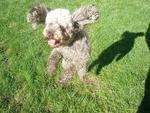
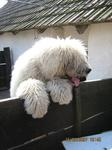
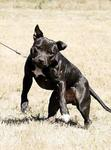
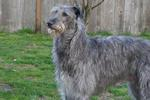
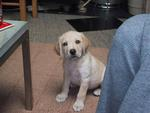
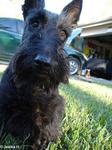
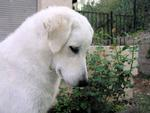
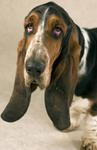
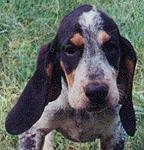
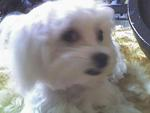
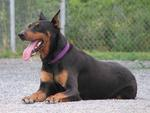
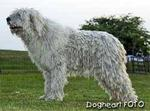
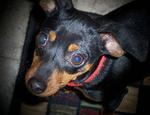
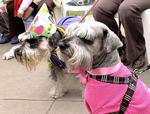
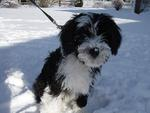
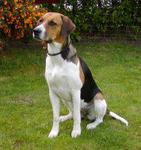
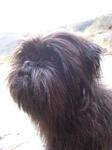
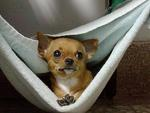
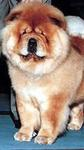
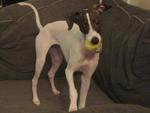

In [16]:
# displaying PIL.Image objects embedded in dataframe
HTML(dogs[['breed', 'image']].to_html(formatters={'image': image_formatter}, escape=False))

Shape: (375, 500, 3)


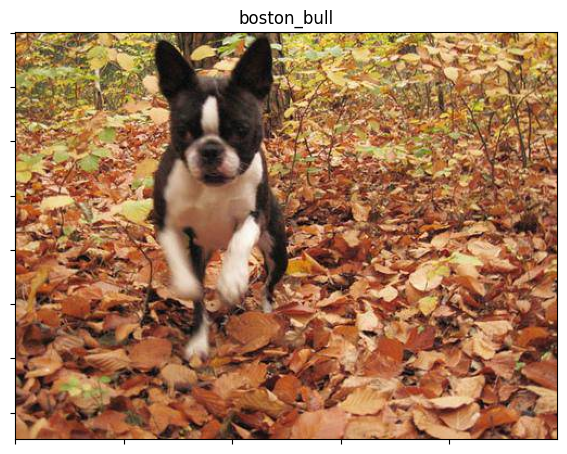

In [17]:
# id_ and breed are already obtained from labels.loc[0]
id_ = labels.loc[0, 'id']
breed = labels.loc[0, 'breed']

# Use the correct train_path defined earlier
# The file name is the id + '.jpg'
file_name = id_ + '.jpg'
# Construct the full path to the image file
image_path = os.path.join(train_path, file_name)

# Read the image using the correct path
img = cv2.imread(image_path)

# Check if the image was loaded successfully before proceeding
if img is not None:
    print('Shape:', img.shape)
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(breed)
    plt.show()
else:
    print(f"Error: Could not load image from {image_path}")
    # You might want to handle this case further, e.g., skip this image, log an error, etc.

In [18]:
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
# Corrected: Changed 'labels_df' to 'labels'
labels['breed_label']= label_encoder.fit_transform(labels['breed'])

labels['breed_label'].unique()

array([ 19,  37,  85,  15,  49,  10,  18,   7,  97,  99, 113,  73,  79,
         2, 118,  89,  68,  21,  38,  83, 106,  58,  12,  26,   0,  67,
        55,  40, 114,  48,  54,  36, 110,  17, 109,  80, 100,  57,  66,
        46,  53,   8,   6,  95,  90,  56,   5,  14,  94,  77,  24,  63,
        84,  16,  42,  33,  71, 115,  29,  93,  88,  72,  65,   3,  69,
        74,  25,  11,   4,  70,  27,  60,  31,  96,   1,  82,  92,  75,
        43,  59,  22, 111,  30,  44,  81, 103, 104,  39,  50, 101,  78,
        23,  28,  35,  52,   9, 112, 116,  64, 117,  98, 105,  62,  61,
        76,  87,  34, 119,  86,  51,  13, 102, 107,  47,  45,  20, 108,
        41,  32,  91])

In [19]:
labels[labels['breed']=='dingo'].head()

,id,breed,breed_label
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
24,00a338a92e4e7bf543340dc849230e75,dingo,37
43,0120343862761d052d6a7ade81625c94,dingo,37
113,02b1c50fb7315423a664f3ce68c94e30,dingo,37
258,060b163b5ad74c889c47b9f421825cdb,dingo,37


In [20]:
def image_preprocessing(image, image_size):
    """ Image Preprocessing """

    # Load Image
    readFlag=cv2.COLOR_BGR2GRAY
    #image = np.asarray(bytearray(resp.read()), dtype="uint8")
    #image = cv2.imdecode(image, readFlag)
    image_gray = cv2.cvtColor(image, readFlag)

    # Crop Image
    mid_row = int(image_gray.shape[0]/2)
    mid_col = int(image_gray.shape[1]/2)
    if image_gray.shape[0]>image_gray.shape[1]:
        image_cropped = image_gray[mid_row-mid_col:mid_row+mid_col,
                                   0:image_gray.shape[1]]
    else:
        image_cropped = image_gray[0:image_gray.shape[0],
                                   mid_col-mid_row:mid_col+mid_row]
        # Rescale Image
    image_rescale = cv2.resize(image_cropped,
                               dsize=(image_size, image_size),
                               interpolation=cv2.INTER_AREA)
    return image_rescale

def plot_befor_after(image):
    """ Compare original and prepared image """

    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    # Plot Original Image
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('original shape: '+str(image.shape))
    # Image Preprocessing
    image_rescale = image_preprocessing(image, image_size)
        # Plot Prepared Image
    axs[1].imshow(image_rescale, cmap='gray')
    axs[1].set_title('rescaled shape: '+str(image_rescale.shape))
    for i in range(2):
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
    plt.show()

In [21]:
image_size = 128

In [22]:
#資料預處理
def prepare_data(base_path, data, image_size):
    """ Read all images into a numpy array """

    X = np.empty((len(data), image_size, image_size), dtype=np.uint8)
    # Keep track of the row index for X array
    x_row_index = 0
    for index, row in data.iterrows(): # Iterate using iterrows for easier access to index and row data
        id_ = row['id']
        file = id_ + '.jpg'
        # Construct the full path to the image file using the correct base path
        image_path = os.path.join(base_path, file)
        image = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if image is None:
            print(f"Warning: Could not load image from {image_path}. Skipping.")
            continue # Skip to the next iteration if image is not loaded

        # Process the image and add it to the numpy array
        image_rescaled = image_preprocessing(image, image_size)
        X[x_row_index, :, :] = image_rescaled
        x_row_index += 1 # Increment index only if image was successfully processed

    # If some images were skipped, resize X to the actual number of processed images
    if x_row_index < len(data):
        X = X[:x_row_index, :, :]

    X = X.astype('float32')/255
    return X

In [23]:
# Update the calls to prepare_data with the correct paths
X_train = prepare_data('dog-breed-identification/train/', labels, image_size)
X_test = prepare_data('dog-breed-identification/test/', samp_subm, image_size)

print("Data preparation complete.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Data preparation complete.
Shape of X_train: (10222, 128, 128)
Shape of X_test: (10357, 128, 128)


In [24]:
#品種標籤（breed）轉換為 One-Hot 編碼格式
y_train = labels['breed']
y_train = pd.get_dummies(y_train)

In [29]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape the data to add a channel dimension for the CNN
X_train = X_train.reshape(-1,image_size,image_size,1)
X_val = X_val.reshape(-1,image_size,image_size,1)
X_test = X_test.reshape(-1,image_size,image_size,1)
#顯示訓練集和驗證集的形狀（資料維度），確認資料是否正確分割與處理
print('Shape train data:', X_train.shape)
print('Shape val data:', X_val.shape)
print('Shape test data:', X_test.shape) # Added print for test shape for completeness

Shape train data: (8177, 128, 128, 1)
Shape val data: (2045, 128, 128, 1)
Shape test data: (10357, 128, 128, 1)


In [30]:
#第一組卷積層
CNN_model = Sequential()
CNN_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (image_size, image_size, 1)))
CNN_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
CNN_model.add(MaxPool2D(pool_size=(2,2)))
CNN_model.add(Dropout(0.15))

#第二組卷積層:通道數擴增為 64
CNN_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
CNN_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
CNN_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
CNN_model.add(Dropout(0.15))


CNN_model.add(Flatten())
#model.add(Dense(256, activation = "relu"))
#model.add(Dropout(0.3))
CNN_model.add(Dense(120, activation = "softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
#設定優化器、損失函數和評估指標
CNN_model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     7,864,440 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,946,328 (30.31 MB)

 Trainable params: 7,946,328 (30.31 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
epochs = 10
batch_size = 128


CNN_history = CNN_model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 530ms/step - accuracy: 0.0091 - loss: 4.8138 - val_accuracy: 0.0196 - val_loss: 4.7782
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 141ms/step - accuracy: 0.0210 - loss: 4.7301 - val_accuracy: 0.0240 - val_loss: 4.6453
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.0542 - loss: 4.4202 - val_accuracy: 0.0357 - val_loss: 4.5859
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.1693 - loss: 3.8019 - val_accuracy: 0.0372 - val_loss: 4.7316
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.4986 - loss: 2.2062 - val_accuracy: 0.0357 - val_loss: 6.7809
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.8568 - loss: 0.5965 - val_accuracy: 0.0347 - val_loss: 10.6548
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9716 - loss: 0.1288 - val_accuracy: 0.0347 - val_loss: 15.2243
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9904 - loss: 0.0596 - val_acc

In [43]:
# ---------- 最終平均統計 ----------
# Ensure train_losses, val_losses, val_accs, and best_acc are defined from the training loop cell

# Extract metrics from the CNN_history object
train_losses = CNN_history.history['loss']
val_losses = CNN_history.history['val_loss']
val_accs = CNN_history.history['val_accuracy'] # Note: Keras uses 'val_accuracy'

# Calculate the best validation accuracy
best_acc = max(val_accs)

# Calculate average statistics
avg_train_loss_total = sum(train_losses) / len(train_losses) if train_losses else 0
avg_val_loss_total = sum(val_losses) / len(val_losses) if val_losses else 0
avg_val_acc_total = sum(val_accs) / len(val_accs) if val_accs else 0

print("\n📊 訓練完成統計：")
print(f"Average Train Loss: {avg_train_loss_total:.4f}")
print(f"Average Val Loss:   {avg_val_loss_total:.4f}")
print(f"Average Val Acc:    {avg_val_acc_total:.4f}")
print(f"Best Val Acc:       {best_acc:.4f}")

# The PyTorch specific prediction code below is not needed as the notebook uses Keras
# 預測
# model.eval()
# all_predictions = []

# with torch.no_grad():
#     for images, img_ids in tqdm(test_loader):
#         images = images.to(device)
#         outputs = model(images)
#         probs = torch.softmax(outputs, dim=1).cpu().numpy()  # 機率

#         for img_id, prob in zip(img_ids, probs):
#             all_predictions.append([img_id] + prob.tolist())


📊 訓練完成統計：
Average Train Loss: 2.0574
Average Val Loss:   10.2916
Average Val Acc:    0.0328
Best Val Acc:       0.0372


In [41]:
# 預測
test_predictions = CNN_model.predict(X_test)

# 從 one-hot label 拿到分類名稱（狗的品種）
breed_columns = y_train.columns.tolist()

# 建立預測結果的 dataframe
submission_df = pd.DataFrame(test_predictions, columns=breed_columns)

# 插入 id 欄位（第一欄）
submission_df.insert(0, 'id', samp_subm['id'])

# 儲存為 submission 檔案
submission_df.to_csv("submission_cnn.csv", index=False)

print("submission_cnn.csv 已產生完成，可上傳至 Kaggle 評分。")


324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
submission_cnn.csv 已產生完成，可上傳至 Kaggle 評分。
